In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [ ]:
#Read dataset
df = pd.read_csv('data_football_ratings.csv')
df = df[df['is_human'] == 1] #Filter human only

In [ ]:
def handle_scaling(rater, x):
    if rater == "Bild":
        out = (7-x) * 10 / 6
    elif rater == "Kicker":
        out = (7-x) * 10 / 6
    else:
        out = x

    return out

In [ ]:
rating_scaled = [handle_scaling(item[7], item[9]) for item in df.values]
df['rating_scaled'] = rating_scaled

In [ ]:
df = pd.concat([df, pd.get_dummies(df['pos_role'])], axis=1)

In [ ]:
df = df.groupby(['player', 'date']).agg('mean').reset_index() #Average multiple rater's rating

<ipython-input-143-13c607d02425>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['player', 'date']).agg('mean').reset_index() #Average multiple rater's rating


In [ ]:
df = df.drop(['player','date', 'original_rating', 'is_human'], axis=1) #Drop unused columns

In [ ]:
df.corr()["rating_scaled"].abs().sort_values(ascending=False)[:40]

rating_scaled             1.000000
lost                      0.421700
win                       0.401541
goals                     0.374176
betweenness2goals         0.278048
shots_ontarget            0.259923
assists                   0.208128
flow_success              0.158515
countattack               0.156727
minutesPlayed             0.149997
flow_centrality           0.133425
saves_itb                 0.130532
touches                   0.128880
lballs_acc                0.122620
chances2score             0.119327
GK                        0.115346
tballs_acc                0.110294
saves_otb                 0.105854
grduels_w                 0.104906
is_home_team              0.101270
keypasses                 0.096388
passes_acc                0.094902
lballs_inacc              0.093724
drib_success              0.092984
degree_centrality         0.092437
Sub                       0.083976
poss_lost                 0.083068
shots_offtarget           0.081297
betweenness_centrali

<Axes: >

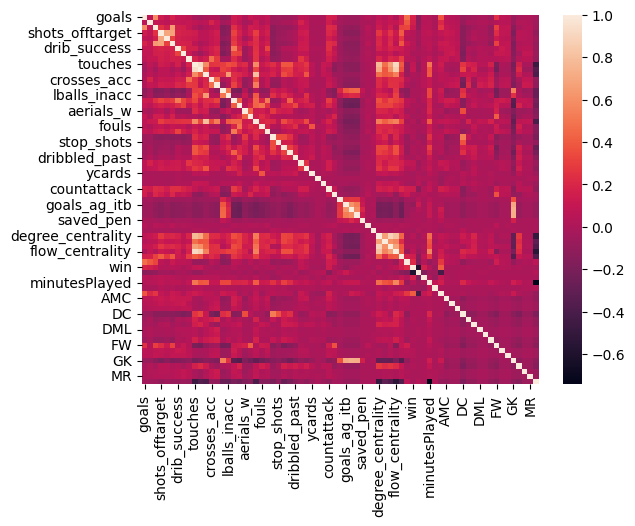

In [ ]:
import seaborn as sns

sns.heatmap(df.corr())

<ipython-input-164-d89ea97d0cad>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['rating_scaled'])


<Axes: xlabel='rating_scaled', ylabel='Density'>

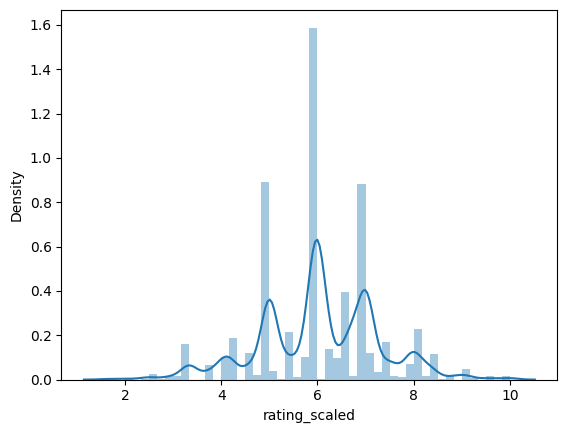

In [ ]:
sns.distplot(df['rating_scaled'])

In [ ]:
#Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=['rating_scaled']).values, df['rating_scaled'].values, test_size=0.2, random_state=42)

In [ ]:
#Train Model
X = X_train
y = Y_train

svr_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', SVR())
])
svr_model.fit(X, y)

linreg_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])
linreg_model.fit(X, y)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LinearRegression())])

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', DecisionTreeRegressor())
])
tree.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DecisionTreeRegressor())])

In [ ]:
#Make prediction from test
svr_pred = svr_model.predict(X_test)
linreg_pred = linreg_model.predict(X_test)

In [ ]:
tree_pred = tree.predict(X_test)

In [ ]:
#Error evaluation
svr_error = [mean_absolute_error(Y_test, svr_pred),
             mean_squared_error(Y_test, svr_pred, squared=False),
             mean_absolute_percentage_error(Y_test, svr_pred),
             r2_score(Y_test, svr_pred)]

linreg_error = [mean_absolute_error(Y_test, linreg_pred),
                mean_squared_error(Y_test, linreg_pred, squared=False),
                mean_absolute_percentage_error(Y_test, linreg_pred),
                r2_score(Y_test, linreg_pred)]

In [ ]:
tree_error = [mean_absolute_error(Y_test, tree_pred),
                mean_squared_error(Y_test, tree_pred, squared=False),
                mean_absolute_percentage_error(Y_test, tree_pred),
                r2_score(Y_test, tree_pred)]

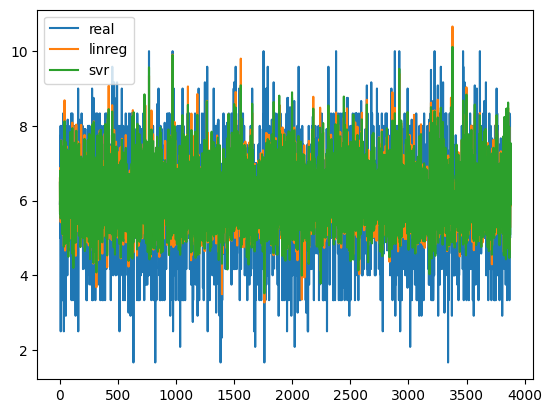

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(Y_test)), Y_test, label='real')
plt.plot(range(len(linreg_pred)), linreg_pred, label='linreg')
plt.plot(range(len(svr_pred)), svr_pred, label='svr')
plt.legend()
plt.show()

In [ ]:
#Error table MinMaxScaler
pd.DataFrame([svr_error, linreg_error, tree_error], columns=['MAE', 'RMSE', 'MAPE', 'R2'], index=['SVR', 'Linear Regression', 'Tree'])

,MAE,RMSE,MAPE,R2
SVR,0.745600,0.965804,0.142609,0.414721
Linear Regression,0.759586,0.977929,0.143578,0.399932
Tree,1.032114,1.356411,0.191249,-0.154432


In [ ]:
#Error table StandardScaler
pd.DataFrame([svr_error, linreg_error], columns=['MAE', 'RMSE', 'MAPE', 'R2'], index=['SVR', 'Linear Regression'])

,MAE,RMSE,MAPE,R2
SVR,0.745600,0.965804,0.142609,0.414721
Linear Regression,0.759586,0.977929,0.143578,0.399932
